In [1]:
import pandas as pd
import numpy as np
import random
from numpy import arange 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.collections as collections
import matplotlib.gridspec as gridspec
import os
import csv
import scipy.misc
from scipy.stats import bernoulli
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2

%matplotlib inline

In [2]:
# Some useful constants

log_path = './data/driving_log.csv'
img_path = './data/IMG'
rolling_window = 3
amp_factor = 1.5
steering_offset = 0.1


In [3]:
###Load Driving Log data into system
data = pd.read_csv(log_path)

left = []
center = []
right = []
steering = data['steering']
steering = steering.astype(np.float32)

for i in range(len(data)):
    left.append(data['left'][i].split('IMG')[1])
    center.append(data['center'][i].split('IMG')[1])
    right.append(data['right'][i].split('IMG')[1])

In [52]:
data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [5]:
###Apply n frames moving average to steering inputs 
df = pd.DataFrame(steering)
smooth = df.rolling(rolling_window,center=True).mean()

In [6]:
###Also apply the steering offset to left or right camera images:
smooth_l = df.rolling(rolling_window,center=True).mean()+steering_offset
smooth_r = df.rolling(rolling_window,center=True).mean()-steering_offset

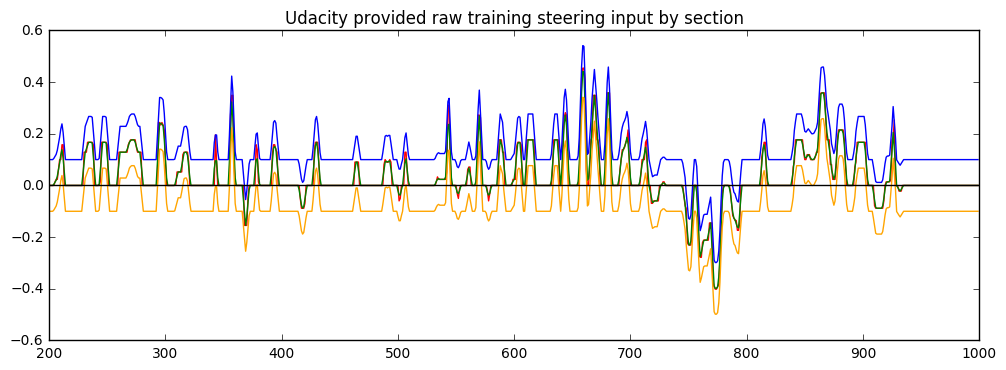

In [7]:
#Plot the steering angle for each frame, show the section form 200 to 1600.
#Overall, the steering range from -1 to 1. 
#Somehow, the steering input is not smooth, I will further investagate into it. 

t = np.arange(0.0, len(center), 1)[200:1000]

fig, ax = plt.subplots(figsize =(12,4))
ax.set_title('Udacity provided raw training steering input by section')
ax.plot(t, steering[200:1000], color='red')
ax.plot(t, smooth[200:1000], color='green')
ax.plot(t, smooth_l[200:1000], color='blue')
ax.plot(t, smooth_r[200:1000], color='orange')
ax.axhline(0, color='black', lw=1)


plt.show()

In [8]:
###Merge Left, Center and Right Camera image together...
X_all = np.concatenate((center[200:8000], left[200:8000], right[200:8000]), axis = 0)
y_all = np.concatenate((smooth[200:8000], smooth_l[200:8000], smooth_r[200:8000]), axis = 0)

In [9]:
###Shuffle all samples
X_all, y_all = shuffle(X_all, y_all)

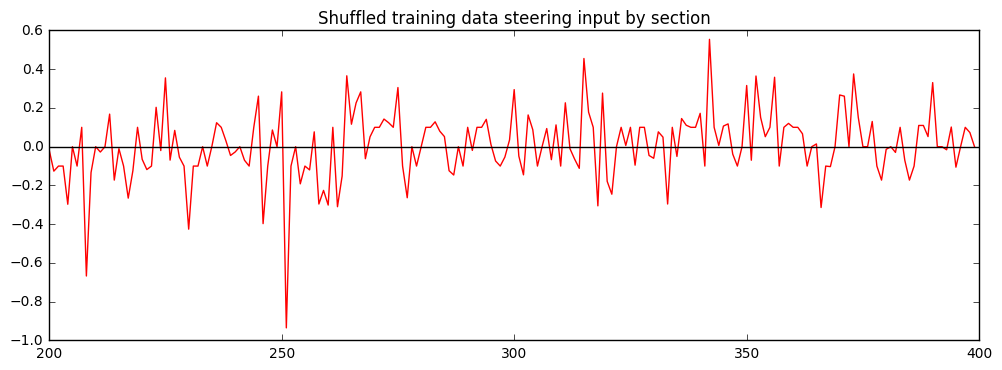

In [10]:
#Plot the steering angle for each frame, show the section form 200 to 1600.
#Overall, the steering range from -1 to 1. 
#Somehow, the steering input is not smooth, I will further investagate into it. 

t = np.arange(0.0, len(y_all), 1)[200:400]

fig, ax = plt.subplots(figsize =(12,4))
ax.set_title('Shuffled training data steering input by section')
ax.plot(t, y_all[200:400], color='red')
#ax.plot(t, smooth[200:1000], color='green')
#ax.plot(t, smooth_l[200:1000], color='blue')
#ax.plot(t, smooth_r[200:1000], color='orange')
ax.axhline(0, color='black', lw=1)


plt.show()

The zero value steering inputs are replaced with left and right camera images and offset steering values.   

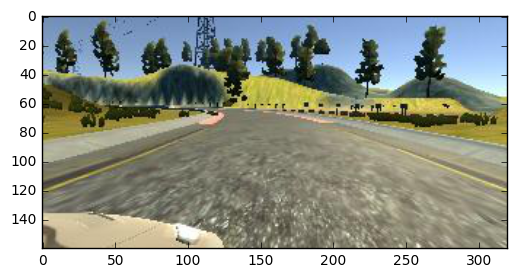

In [11]:
#reading in an image
index = np.random.randint(1,len(X_all))
img = scipy.misc.imread(img_path+X_all[index])

plt.imshow(img) 

In [12]:
### Split training set and validation set
split_point = 128*150   # 128*150=19200

X_train = X_all[:int(split_point)]
y_train = y_all[:int(split_point)]

X_val = X_all[-int(len(X_all)-split_point):]
y_val = y_all[-int(len(X_all)-split_point):]

num_train_images = len(X_train)
num_val_images = len(X_val)

print ('Number of Training Images: '+str(num_train_images))
print ('Number of Validation Images: '+str(num_val_images))

Number of Training Images: 19200
Number of Validation Images: 4200


In [13]:
def lookahead_crop(image, top_percent=0.35, bottom_percent=0.1):
    """
    Inspired by human driver. 
    Look farther can smooth out the steering wheel angle. 
    Crops an image based on driver lookahead requirment, aim for the apex point or vannish point.  

    """
    rows,cols,ch = image.shape
    image = image[int(rows*top_percent):int(rows-rows*bottom_percent),:]

    return image

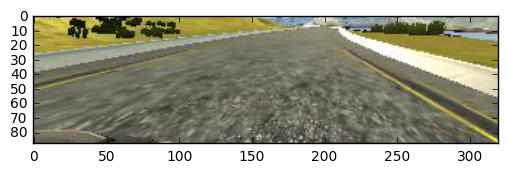

In [14]:
#reading in an image, apply lookahead_crop()
index = np.random.randint(1,len(X_all))
img = scipy.misc.imread(img_path+X_all[index])
img = lookahead_crop(img, 0.35, 0.1)
plt.imshow(img) 

In [19]:
def horizontal_crop(image, angle):
    #random pan the camera from left to right in a small pixel shift, between -24 to 24 pixels, compensate the steering angle 
    #width = 240
    rows,cols,ch = image.shape
    width = int(cols*0.8)
    
    x_var = int(np.random.uniform(-24,24))
        
    crop_img = image[0:rows,int(cols/2-width/2+x_var):int(cols/2+width/2+x_var)]
    
    angle_factor = 0.002 # degree per each shifted pixel
    adj_angle = angle + angle_factor*x_var
    
    return crop_img, adj_angle

In [20]:
def resize(image, new_dim):
    
    return scipy.misc.imresize(image, new_dim)

In [21]:
def random_flip(image, steering_angle, flipping_prob=0.5):
    
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle


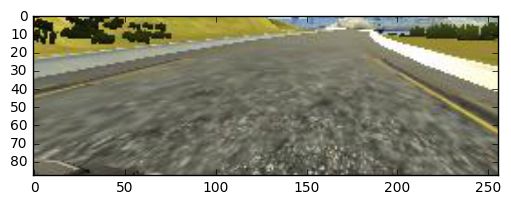

In [22]:
#reading in an image, apply horizontal_crop()
img,angle = horizontal_crop(img, y_all[index])
plt.imshow(img) 

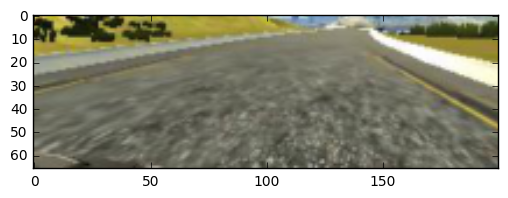

In [23]:
#reading in an image, apply resize()
img = resize(img, (66,200))
plt.imshow(img) 

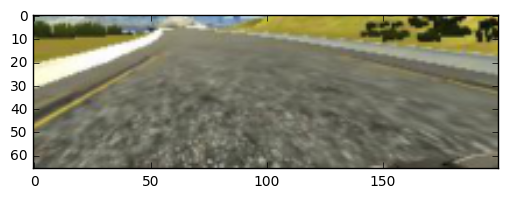

In [24]:
#reading in an image, apply random_flip()
img, angle = random_flip(img, angle, 1)
plt.imshow(img) 

In [26]:
def dark_image(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img[:,:,2] = img[:,:,2]*np.random.uniform(0.1,1.2)
    dst = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return dst

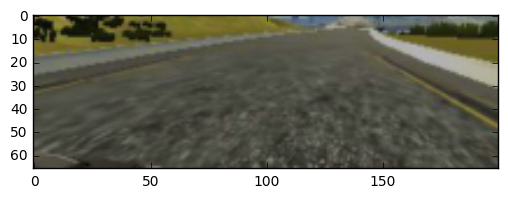

In [27]:
img = dark_image(img)
plt.imshow(img) 

In [28]:
def mask_image(img):
    """
    Applies an image mask.
    region_of_interest(img, vertices):
    """
    rows,cols,ch = img.shape
    ax = int(cols*(np.random.uniform(-0.5,0.5)))
    bx = int(ax+cols*np.random.uniform(-0.5,0.5))
    cx = int(np.random.uniform(0, 80))
    dx = int(cols-cx)
    p = (np.random.uniform(-0.5,0.5))
    #vertices
    vertices = np.array([[(dx,rows),(ax,int(p*rows)), (bx, int(p*rows)), (cx,rows)]], dtype=np.int32)
    shadow = np.random.randint(1, 200)
    mask = np.full_like(img, shadow)
        
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

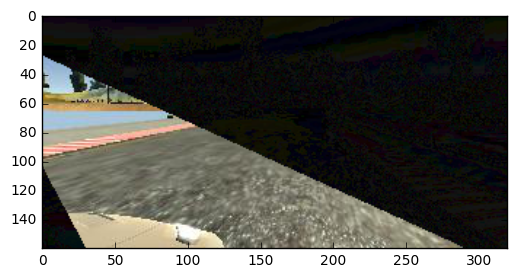

In [30]:
index = np.random.randint(1,len(X_all))
img = scipy.misc.imread(img_path+X_all[index])


img = mask_image(img)
plt.imshow(img) 

In [44]:
def random_shear(image, steering_angle, shear_range=100):

    # Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk

    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering
    return image, steering_angle

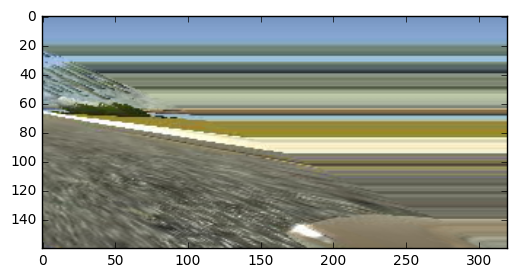

In [45]:
index = np.random.randint(1,len(X_all))
img = scipy.misc.imread(img_path+X_all[index])
img, _ = random_shear(img, y_all[index], 200)
plt.imshow(img) 

In [50]:
def plot_random_image(n_row,n_col,X,y):

    plt.figure(figsize = (2.5*n_col,1.2*n_row))
    gs1 = gridspec.GridSpec(n_row,n_col)
    gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes. 

    for i in range(n_row*n_col):
        ax1 = plt.subplot(gs1[i])
        index = np.random.randint(1,len(y))
        img = mpimg.imread(img_path+X[index])
        dark_img = dark_image(img)
        masked_img = mask_image(dark_img)
        lookahead_img = lookahead_crop(masked_img, top_percent, bottom_percent)
        cropped_img,adj_angle = horizontal_crop(lookahead_img,y[index])
        sheared_img,dst_angle = random_shear(cropped_img, adj_angle, 100)
        if i%2 ==1:
            plt.imshow(resize(np.fliplr(sheared_img),resize_dim))
            plt.title(str(np.round(-dst_angle,5)),fontsize=8)
            plt.axis('off')
        if i%2 ==0:
            plt.imshow(resize(sheared_img,resize_dim))
            plt.title(str(np.round(dst_angle,5)),fontsize=8)
            plt.axis('off')
                
    plt.show()

ploting random images in train dataset......


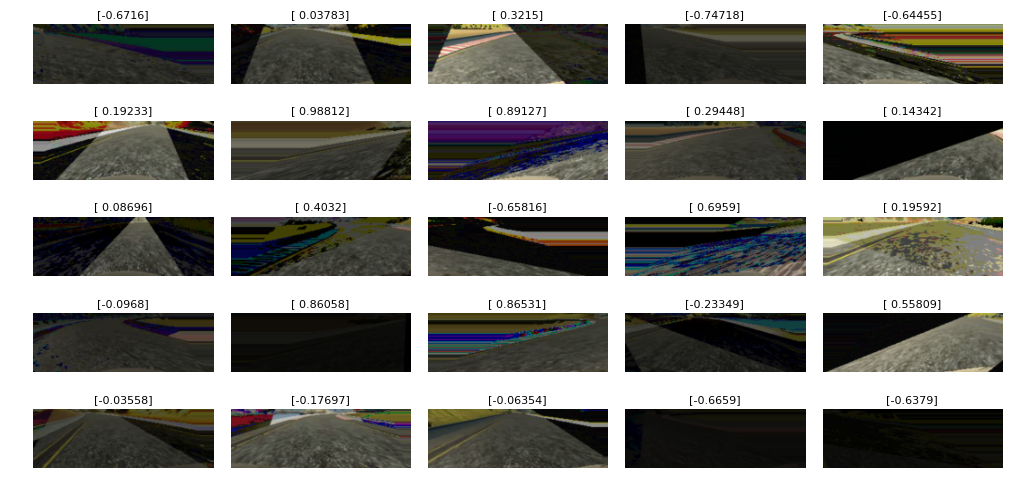

In [51]:
print('ploting random images in train dataset......')
#crop range dependents on speed and moving average frames
top_percent = 0.35
bottom_percent = 0.1
resize_dim=(66, 200)
do_shear_prob=0.2
shear_range=100
plot_random_image(5,5,X_train,y_train)